In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#--------------------------------------------------
# Create some syntetic data
size = 10000

Year = np.random.randint(1998, high=2021, size=size, dtype=int)
LotArea = np.random.randint(50, high=2001, size=size, dtype=int)
nFlor = np.random.randint(1, high=11, size=size, dtype=int)
BedAbv = np.random.normal(loc=50.0, scale=5.0, size=size)
county = np.random.randint(1, high=51, size=size, dtype=int)

# Syntetic categorical data
locs = np.array(['north', 'south', 'center','east','west'])
Location = np.tile(locs, int(size/5))
np.random.shuffle(Location)

neigh = np.array(['Croxton','Croxton East','Dennis','Merri','Northcote South','Ruckers Hill','Westgarth',
'Preston','Bell','Darebin Park','Gilberton','Northland','Preston Lake','Regent','Regent West','South Preston',
'Sylvester','Reservoir','Gilbank','Regent','Reservoir North','Ruthven','Summerhill','Thornbury','Thornbury North'])
Neighborhood = np.tile(neigh, int(size/25))
np.random.shuffle(Location)

#--------------------------------------------------
# Define a function to obtain prices for later testing the model
def fun_price(y,lot,flor,bed,county):    
    return np.sin(y/2020)*lot*flor + bed - county/2

def col_price(row):
    y = row.Year
    flor = row.nFlor
    lot = row.LotArea
    bed = row.BedAbv
    county = row.county
    return int(fun_price(y,lot,flor,bed,county))

home_data = pd.DataFrame({'Year':Year, 'LotArea':LotArea, 'nFlor':nFlor,'BedAbv':BedAbv, 
                          'county':county, 'Location':Location,'Neighborhood':Neighborhood})
home_data['Price'] = home_data.apply(col_price,axis=1)
#--------------------------------------------------
# Syntetics NaN
iy = [10,100,120,1400]
inf = [123,234]
for i in iy:
    home_data.Year.iloc[i] = np.nan
for i in inf:
    home_data.nFlor.iloc[i] = np.nan
    
home_data

/home/xuxo/.local/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Year,LotArea,nFlor,BedAbv,county,Location,Neighborhood,Price
0,2020.0,110,4.0,54.579182,32,east,Croxton,408
1,2000.0,1299,3.0,53.121050,23,north,Croxton East,3299
2,2002.0,1898,8.0,57.013438,16,south,Dennis,12752
3,2013.0,1527,3.0,43.472348,41,south,Merri,3869
4,2012.0,1344,10.0,50.298764,19,center,Northcote South,11321
...,...,...,...,...,...,...,...,...
9995,2016.0,259,10.0,51.976994,27,center,Reservoir North,2215
9996,2008.0,392,4.0,46.371392,12,south,Ruthven,1354
9997,2002.0,1211,7.0,48.489678,1,east,Summerhill,7140
9998,2014.0,360,5.0,53.420406,44,south,Thornbury,1543


In [22]:
##################################################
#######    Prepare data
##################################################

#--------------------------------------------------------------------------------------------------
# Remove rows with missing target, separate target from predictors
X_full = home_data
X_full.dropna(axis=0, subset=['Price'], inplace=True)

y = X_full.Price
X_full.drop(['Price'], axis=1, inplace=True)

#--------------------------------------------------------------------------------------------------
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

#--------------------------------------------------------------------------------------------------
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

#--------------------------------------------------------------------------------------------------
# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = numerical_cols + categorical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

X_train

,Year,LotArea,nFlor,BedAbv,county,Location
7389,2007.0,1578,1.0,55.497904,33,east
9275,2013.0,95,2.0,55.415461,36,south
2995,2010.0,518,5.0,42.820096,48,center
5316,2019.0,786,5.0,56.431311,1,north
356,2000.0,1120,8.0,45.399594,7,east
...,...,...,...,...,...,...
9225,2001.0,316,3.0,48.415959,49,west
4859,1999.0,1866,1.0,57.234262,20,north
3264,2016.0,1989,5.0,39.084223,38,east
9845,2004.0,1784,8.0,59.247564,1,west


In [23]:
# Building a pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

#--------------------------------------------------------------
# Preprocessing for numerical data (fill NaNs)
numerical_transformer = SimpleImputer(strategy='constant')

#--------------------------------------------------------------
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#--------------------------------------------------------------
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


#--------------------------------------------------------------
#--------------------------------------------------------------
# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
#--------------------------------------------------------------
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)



#--------------------------------------------------------------
# X_train keeps its structure!
#--------------------------------------------------------------



print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 15.346205000000001


In [24]:
# simple cross validation

from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X_full, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 15.354633000000002


In [27]:
# Building a function for cross validation

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score


def get_score(n_estimators, folds):
    """Return the average MAE over 5 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    #--------------------------------------------------------------
    # Preprocessing for numerical data (fill NaNs)
    numerical_transformer = SimpleImputer(strategy='constant')

    #--------------------------------------------------------------
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    #--------------------------------------------------------------
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)])


    #--------------------------------------------------------------
    #--------------------------------------------------------------
    # Define model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)

    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    scores = -1 * cross_val_score(my_pipeline, X_full, y,
                                  cv=folds,
                                  scoring='neg_mean_absolute_error')
    return scores.mean()

results = {i:get_score(i,5) for i in [50,100,150,200,250,300]}

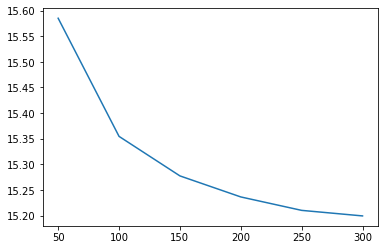

In [28]:
# Showing last results

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()